In [22]:
from rajvi_mapbox_api import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
import folium

In [23]:
branchRadii = gpd.read_file('../data/clean/branches.csv')
populationDemographics = pd.read_csv('../data/clean/population_demographics.csv')
api = MapboxAPI() 

In [24]:
# prepping base branchRadii dataframe
branchRadii[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchRadii['LOCATION']]
branchRadii.loc[:, 'LATITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LATITUDE'])
branchRadii.loc[:, 'LONGITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LONGITUDE'])
branchRadii.head()

branchRadii = branchRadii[(branchRadii['BRANCH'] != 'Roosevelt')]
branchRadii = branchRadii.drop(['HOURS OF OPERATION', 'ADDRESS', 
                                'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE', 'PERMANENTLY_CLOSED'], axis=1)
branchRadii.reset_index(inplace = True)
branchRadii = branchRadii.set_crs('epsg:4326')


In [25]:
# creating and prepping other data frames to be mapped -- these will not be modified later

# census map prep
censusTracts = populationDemographics[['geoid','geometry','qualifying name', 'current land area (sq. m)', 'current water area (sq. m)', ]]
branchLocsOnly=branchRadii[['BRANCH','LOCATION']]

censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

# branch locations map prep
branchLocsOnly.crs = 'EPSG:4326'
branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
branchLocsOnly = branchLocsOnly.drop(columns='LOCATION')

branchLocsOnly = gpd.GeoDataFrame(
    branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:4326")

/tmp/ipykernel_1941803/2420311521.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
/tmp/ipykernel_1941803/2420311521.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]


In [26]:
# prepping data frames to add surrounding radius geometry
branchRadii7 = branchRadii.copy(deep = True)
branchRadii7 = branchRadii7.set_crs('epsg:4326')
for i in range(branchRadii7.shape[0]):
    api_response =  api.get_data((branchRadii7.loc[i,'LATITUDE'],branchRadii7.loc[i,'LONGITUDE']), 7)
    branchRadii7.loc[i,'geometry'] = shape(api_response)
    
branchRadii15 = branchRadii.copy(deep = True)
branchRadii15 = branchRadii15.set_crs('epsg:4326')
for i in range(branchRadii15.shape[0]):
    api_response =  api.get_data((branchRadii15.loc[i,'LATITUDE'],branchRadii15.loc[i,'LONGITUDE']), 15)
    branchRadii15.loc[i,'geometry'] = shape(api_response)


In [27]:
# remove smaller from larger 
def outerRingOnly(largerTimeFrame, smallerTimeFrame):
    largerTimeFrame['geometry'] = largerTimeFrame.difference(smallerTimeFrame)
    return largerTimeFrame

In [28]:
branchRadii15Mod = outerRingOnly(branchRadii15, branchRadii7)

In [29]:
def removeOverlapWithinLayer (largeTimeFrame, smallerTimeFrame):
    outerRadiusNoOverlap = gpd.GeoDataFrame(columns=['BRANCH','geometry'], geometry='geometry', crs='EPSG:4326')
    for i in range(largeTimeFrame.shape[0]):    
        oneLargeRadius = gpd.GeoDataFrame({'BRANCH': [largeTimeFrame.loc[i,'BRANCH']],'geometry': [largeTimeFrame.loc[i,'geometry']]})
        #oneLargeRadius = oneLargeRadius.set_crs(crs='EPSG:4326')
        #oneLargeRadius = oneLargeRadius.to_crs('espg=4326')
        for j in range(largeTimeFrame.shape[0]):
                
            rotatingSmallRadius = gpd.GeoDataFrame({'BRANCH': [smallerTimeFrame.loc[j,'BRANCH']],'geometry': [smallerTimeFrame.loc[j,'geometry']]})
            outerOnly = oneLargeRadius.difference(rotatingSmallRadius)
            oneLargeRadius['geometry'] = outerOnly[0]
            
            if (i != j):
                rotatingLargeRadius = gpd.GeoDataFrame({'BRANCH': [largeTimeFrame.loc[j,'BRANCH']],'geometry': [largeTimeFrame.loc[j,'geometry']]})
                largerNoOverlap = oneLargeRadius.difference(rotatingLargeRadius)
                oneLargeRadius['geometry'] = largerNoOverlap[0]
                
        outerRadiusNoOverlap = pd.concat([outerRadiusNoOverlap, oneLargeRadius])
        largeTimeFrame.loc[i, 'geometry'] = largerNoOverlap[0]
    return largeTimeFrame

In [30]:
branchRadii15Mod = removeOverlapWithinLayer(branchRadii15, branchRadii7)

/opt/tljh/user/lib/python3.9/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting o

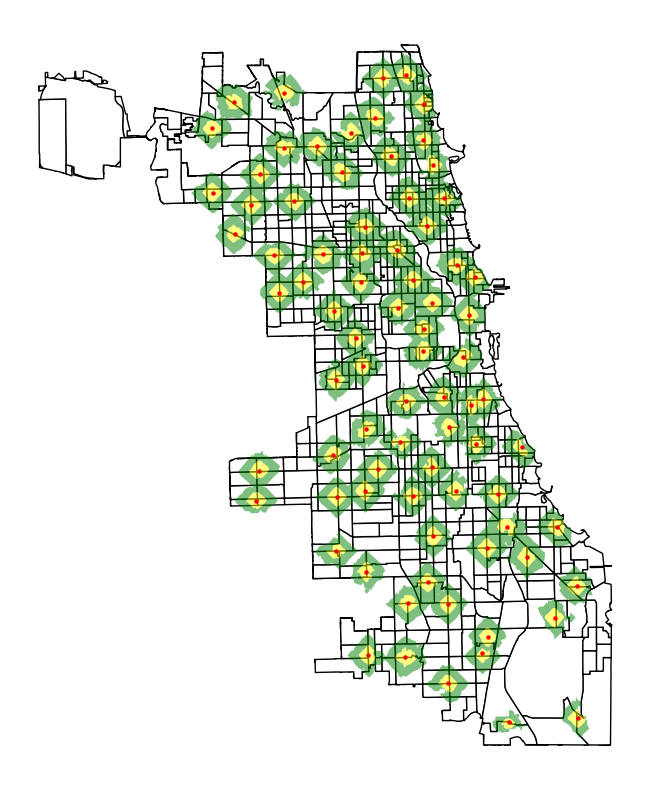

In [31]:
# plots all overlapping maps (census, lib locations, and each radius)

fig, ax = plt.subplots(1, figsize=(10, 10))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black')
ax.axis('off')

branchRadii7.plot(ax=base, alpha = .5, color = 'yellow')
branchRadii15Mod.plot(ax=base, alpha = .5, color = 'green')
                                    
branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);